In [1]:
import os, sys, time
sys.path.append("../src")

from tqdm.notebook import tqdm
import pandas as pd
import json
import numpy as np
import torch
from scipy import stats
from datasets import load_from_disk
from transformers import ViTForImageClassification
from utils.helper import get_device
from utils.vit_util import transforms, transforms_c100
from utils.constant import ViTExperiment
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
import torch
device = get_device()

2024-05-18 02:14:25.687972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 02:14:26.737890: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-18 02:14:26.738009: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-18 02:14:26.738020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Device: cuda


In [2]:
ds_name = "c100"
# pretrained modelのロード
pretrained_dir = getattr(ViTExperiment, ds_name).OUTPUT_DIR
model = ViTForImageClassification.from_pretrained(pretrained_dir).to(device)
model.eval()
# 対象の設定
start_li = 9
end_li = model.vit.config.num_hidden_layers
used_col = "train"

# datasetごとに違う変数のセット
if ds_name == "c10":
    tf_func = transforms
    label_col = "label"
    num_labels = 10
elif ds_name == "c100":
    tf_func = transforms_c100
    label_col = "fine_label"
    num_labels = 100
else:
    NotImplementedError

In [3]:
# 指定したused_colのデータセットをロード
ds = load_from_disk(os.path.join(ViTExperiment.DATASET_DIR, ds_name))[used_col]
# ラベルのリスト取得
labels = np.array(ds[label_col])
print(f"len(labels): {len(labels)}")
ds = ds.with_transform(tf_func)

len(labels): 50000


tgt_layer=9


tgt_label:   0%|          | 0/100 [00:00<?, ?it/s]

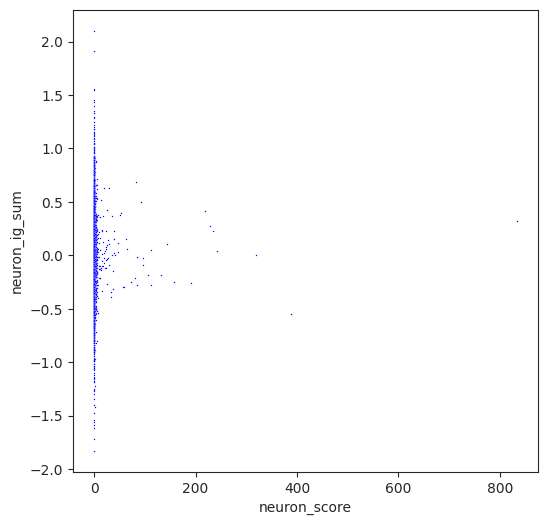

tgt_layer=10


tgt_label:   0%|          | 0/100 [00:00<?, ?it/s]

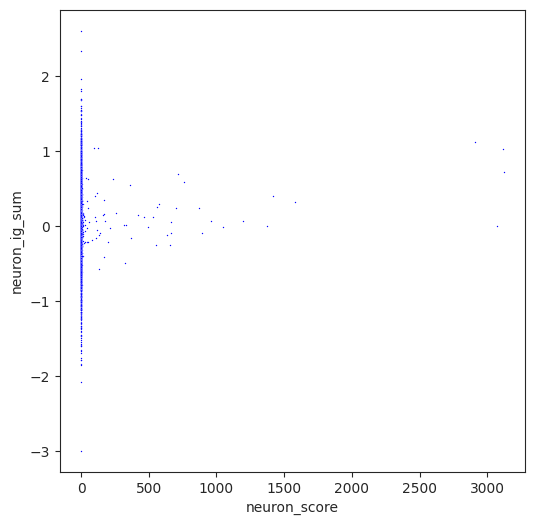

tgt_layer=11


tgt_label:   0%|          | 0/100 [00:00<?, ?it/s]

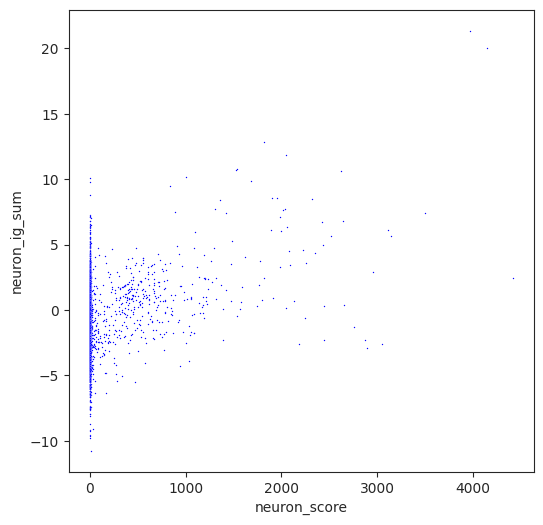

[-0.022371317409576093, 0.006302272320956686, 0.32040422479970987]


In [20]:
# integrated gradientのdir
ig_dir = os.path.join(getattr(ViTExperiment, ds_name).OUTPUT_DIR, "neuron_scores")
im_dir = os.path.join(getattr(ViTExperiment, ds_name).OUTPUT_DIR, f"cache_states_{used_col}")
# tgt_layerごとに全てのラベルにおけるigとneuron_corrの相関係数を計算
corrs = []
for tgt_layer in range(start_li, end_li):
    print(f"tgt_layer={tgt_layer}")
    im_states = torch.load(os.path.join(im_dir, f"intermediate_states_l{tgt_layer}.pt"))
    # numpyに変換しておく
    im_states = im_states.cpu().numpy()
    corr_per_label = []
    for tgt_label in tqdm(range(num_labels), desc="tgt_label"):
        # labelsがtgt_labelのindexを取得
        tgt_idx = np.where(labels == tgt_label)[0]
        # tgt_labelに対するim_statesだけを取得
        tgt_im = im_states[tgt_idx]
        # 対象のレイヤに対象のラベルのサンプルを入れたときのニューロン分散行列を作成
        neuron_cov = np.cov(tgt_im, rowvar=False)

        # # 対象のレイヤに対象のラベルのサンプルを入れたときのニューロン相関マップを作成
        # neuron_corr = np.corrcoef(tgt_im, rowvar=False)
        # # neuron_corrのnanの割合
        # nan_ratio = np.sum(np.isnan(neuron_corr)) / neuron_corr.size
        # print(f"tgt_label={tgt_label}, neuron_corr_nan_ratio={nan_ratio}")
        # # 対象のレイヤの各ニューロンの分散を求める
        # neuron_var = np.var(tgt_im, axis=0)
        # print(neuron_var)
        # neuron_varの範囲を出力
        # print(f"neuron_var: min={np.min(neuron_var)}, max={np.max(neuron_var)}")
        
        # # neuron_corrのヒートマップを可視化
        # plt.figure(figsize=(12, 12))
        # sns.heatmap(neuron_corr, cmap="coolwarm", center=0)
        # plt.title(f"tgt_label={tgt_label}")
        # plt.show()
    
        # neuron_corrの各行の和
        neuron_var = np.diag(neuron_cov)
        neuron_corr_sum = np.nansum(neuron_cov, axis=0) # 自分の分散 + (他の共分散の総和)
        # mean_cov = (neuron_corr_sum - neuron_var) / (neuron_corr_sum.shape[0] - 1)
        # neuron_score = neuron_var + mean_cov
        #  上の実装だと安定性問題あるかも？割り算を使わない形で書き直す (上のneuron scoreの (ニューロン数-1)倍)
        neuron_score = (neuron_corr_sum.shape[0] - 1) * np.diag(neuron_cov) + np.sum(neuron_cov, axis=1)

        # neuron_corr_sumのヒストグラムを可視化
        # plt.figure(figsize=(6, 6))
        # plt.hist(neuron_score.flatten(), bins=100) # 分散が0の変数があると0除算でnanが返される (warning出ます)
        # plt.title(f"tgt_label={tgt_label}")
        # plt.show()
        
        # tgt_labelに対するintegrated_gradientを取得
        ig_path = os.path.join(ig_dir, f"ig_list_l{start_li}tol{end_li}_{tgt_label}.npy")
        tgt_ig = np.load(ig_path)[:, tgt_layer-start_li, :]
        neuron_ig_sum = np.sum(tgt_ig, axis=0)
        # neuron_corr_sumとneuron_ig_sumの相関係数
        corr = np.corrcoef(neuron_score, neuron_ig_sum)[0, 1]
        corr_per_label.append(corr)
        # # neuron_corr_sumとneuron_ig_sumをそれぞれ[0,1]に正規化
        # neuron_corr_sum = (neuron_corr_sum - np.min(neuron_corr_sum)) / (np.max(neuron_corr_sum) - np.min(neuron_corr_sum))
        # neuron_ig_sum = (neuron_ig_sum - np.min(neuron_ig_sum)) / (np.max(neuron_ig_sum) - np.min(neuron_ig_sum))
        # neuron_corr_sumとneuron_ig_sumをそれぞれx, y軸としてsns.jointplotで可視化
        if tgt_label == 0:
            plt.figure(figsize=(6, 6))
            df = pd.DataFrame(columns=["neuron_score", "neuron_ig_sum"], data=np.array([neuron_score, neuron_ig_sum]).T)
            sns.scatterplot(df, x="neuron_score", y="neuron_ig_sum", color="b", s=1)
            plt.show()
    corrs.append(np.mean(corr_per_label))
print(corrs)

# いえること
ニューロン間の相関スコアとintegrated gradientは無相関

10レイヤめだけ相関行列にnanが多すぎるけどなんで？

In [21]:
def judge_test_res(p_value, d_cliff):
    sign = ""
    if d_cliff > 0:
        sign = "(+) "
    elif d_cliff < 0:
        sign = "(-) "
    d_cliff = np.abs(d_cliff)
    # 統計結果の判断基準
    # 有意水準を設定
    sig_005 = 0.05
    sig_001 = 0.01
    # 効果量の閾値
    eff_large = 0.474
    eff_medium = 0.33
    eff_small = 0.147
    # 検定結果を判断して出力を整形
    # 有意水準の判断
    if p_value < sig_001:
        sig = "**"
    elif p_value < sig_005:
        sig = "*"
    else:
        sig = ""
    # 効果量の判断
    if d_cliff >= eff_large:
        eff = "large"
    elif d_cliff >= eff_medium:
        eff = "med."
    elif d_cliff >= eff_small:
        eff = "small"
    else:
        eff = "neg."
    print(eff + sig)
    return sig, eff, sign

tgt_layer=11


tgt_label:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 58, len(other_neuron_corr_sum): 3014


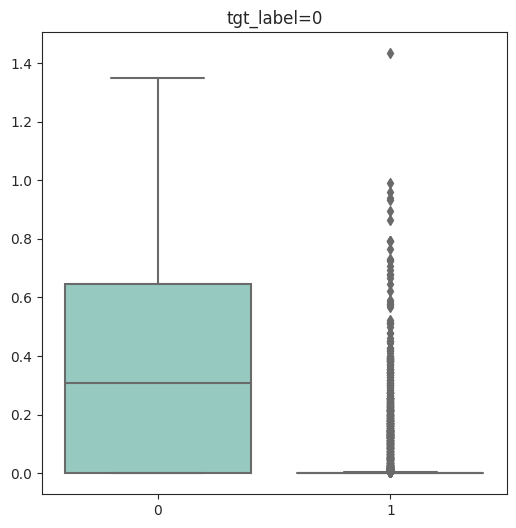

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 43, len(other_neuron_corr_sum): 3029


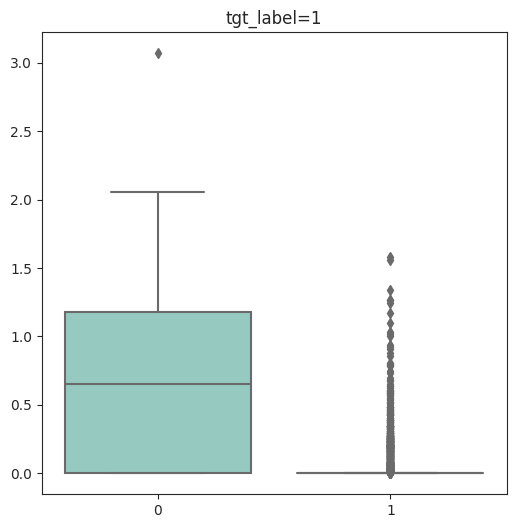

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 97, len(other_neuron_corr_sum): 2975


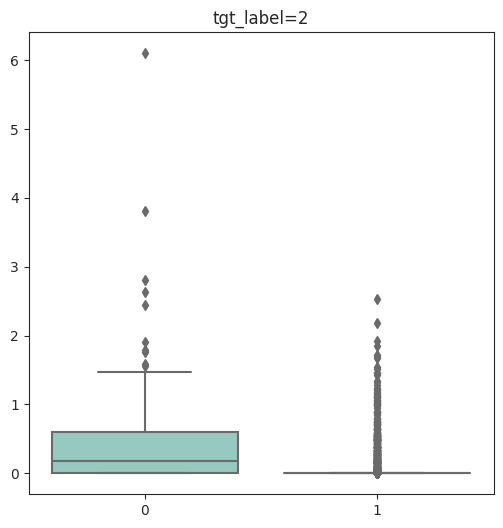

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 53, len(other_neuron_corr_sum): 3019


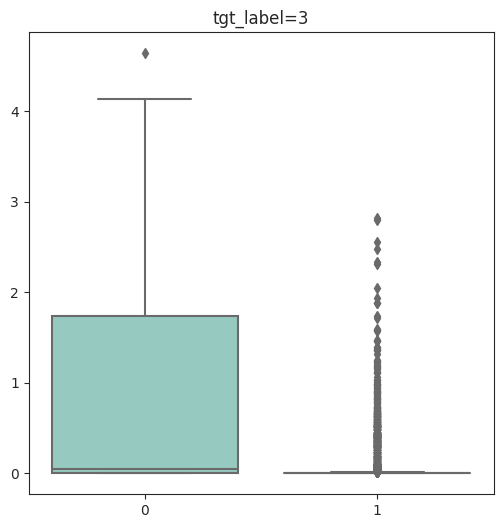

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 43, len(other_neuron_corr_sum): 3029


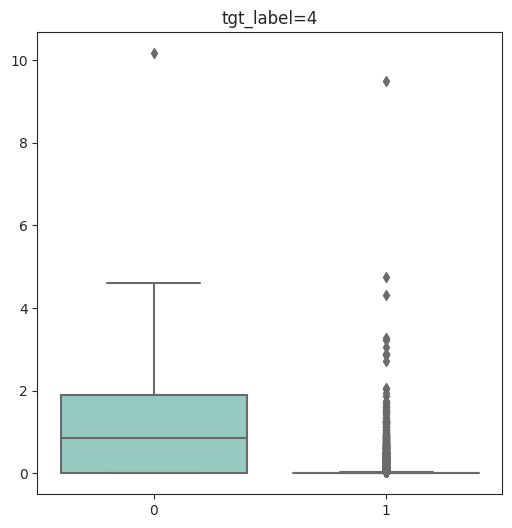

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 159, len(other_neuron_corr_sum): 2913


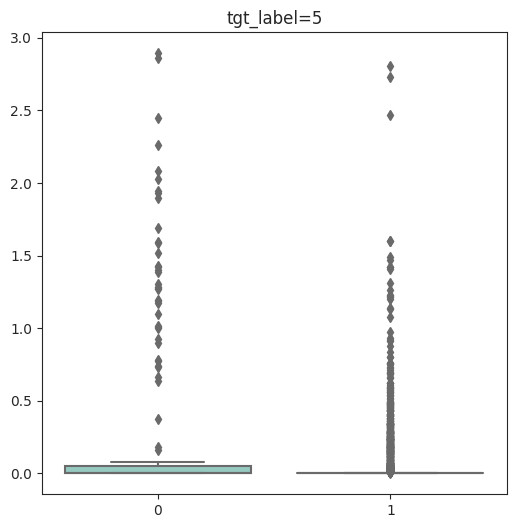

neg.


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 96, len(other_neuron_corr_sum): 2976


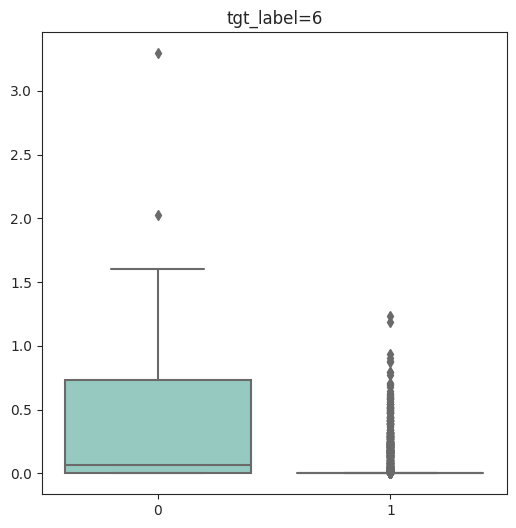

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 128, len(other_neuron_corr_sum): 2944


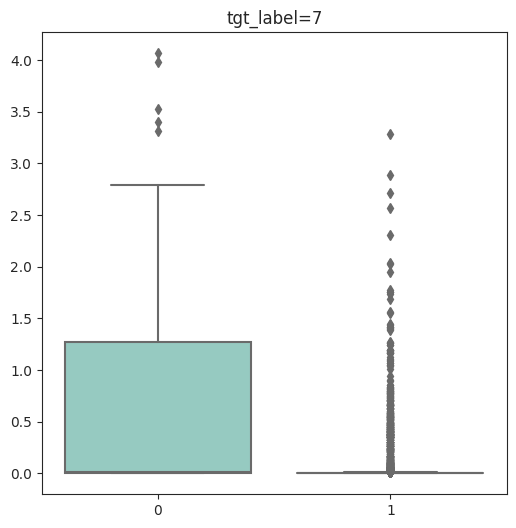

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 109, len(other_neuron_corr_sum): 2963


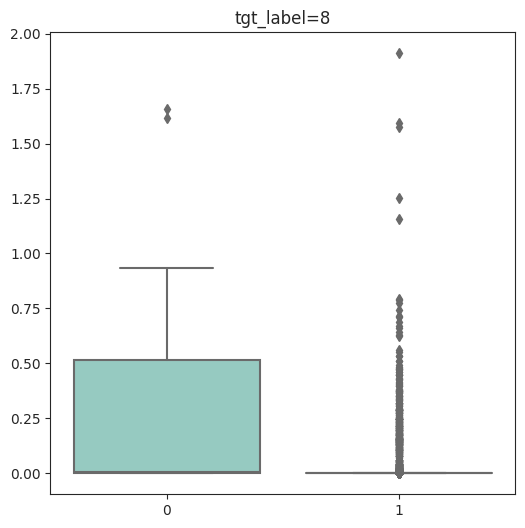

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 46, len(other_neuron_corr_sum): 3026


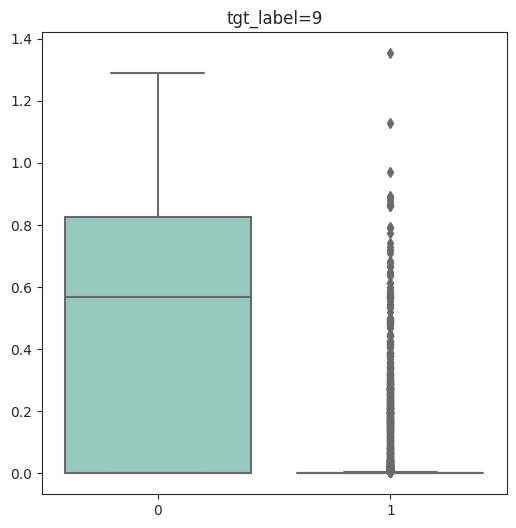

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 114, len(other_neuron_corr_sum): 2958


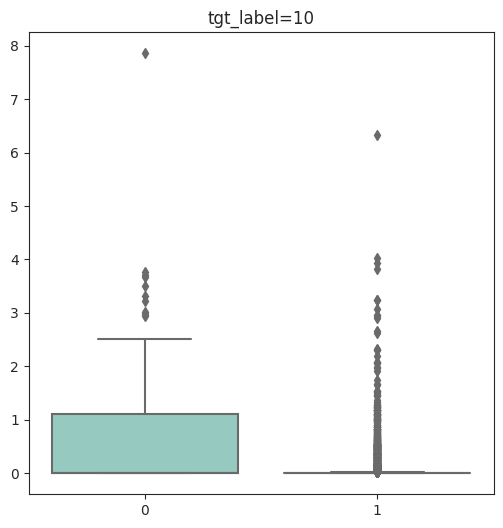

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 59, len(other_neuron_corr_sum): 3013


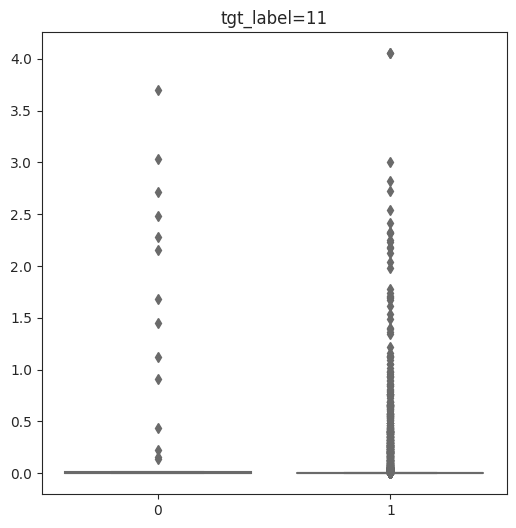

neg.


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 60, len(other_neuron_corr_sum): 3012


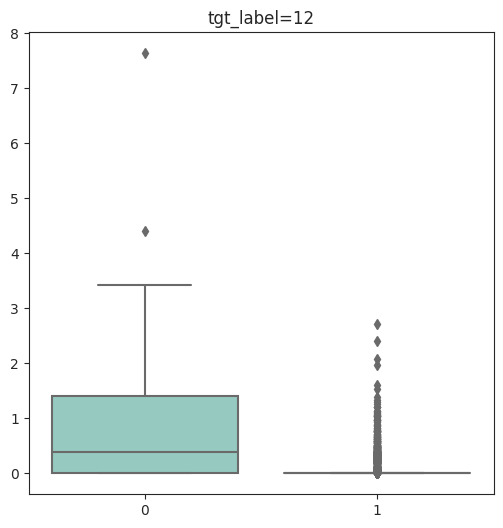

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 60, len(other_neuron_corr_sum): 3012


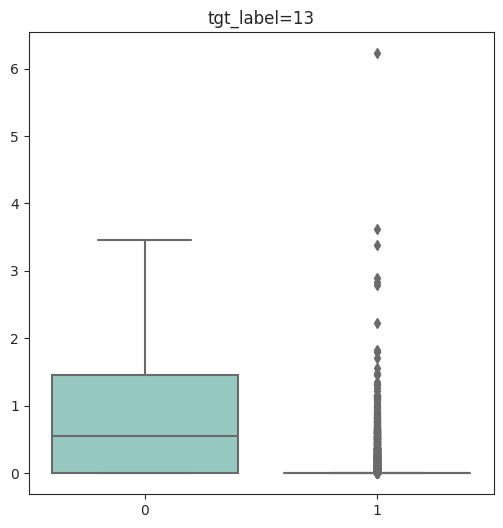

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 51, len(other_neuron_corr_sum): 3021


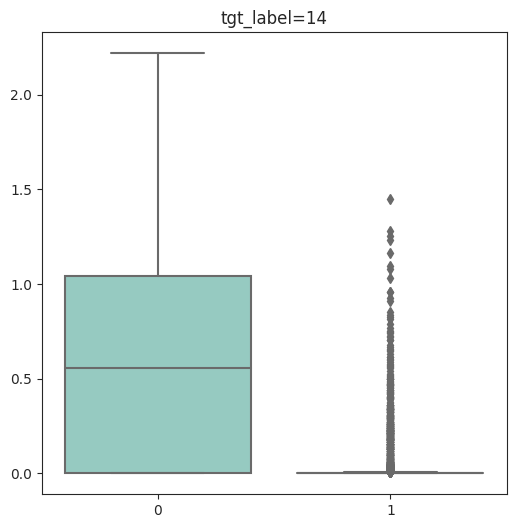

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 84, len(other_neuron_corr_sum): 2988


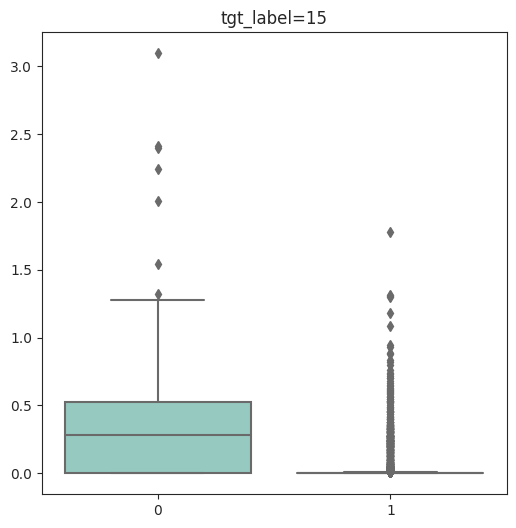

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 50, len(other_neuron_corr_sum): 3022


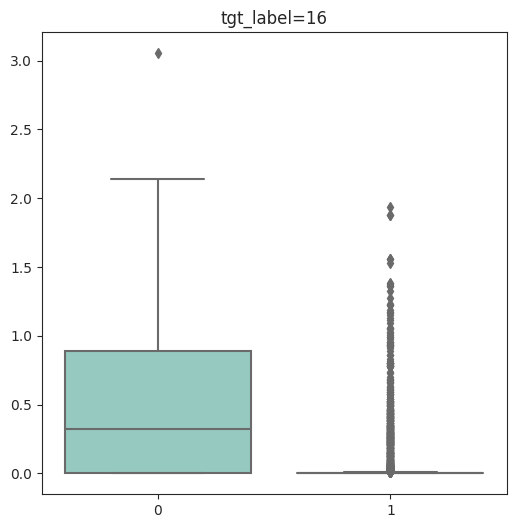

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 72, len(other_neuron_corr_sum): 3000


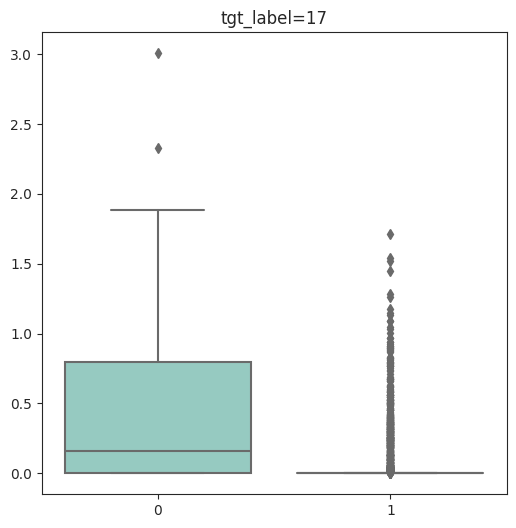

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 70, len(other_neuron_corr_sum): 3002


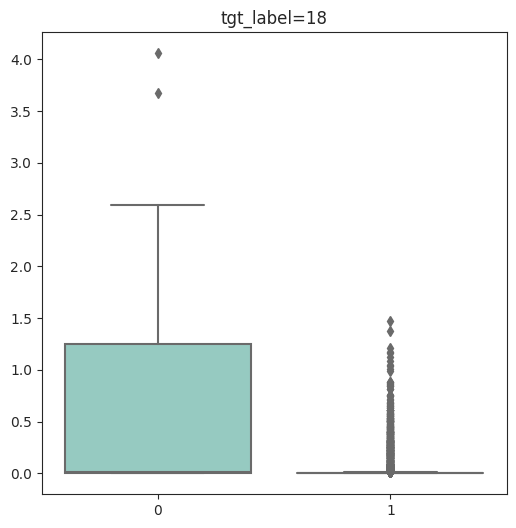

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 126, len(other_neuron_corr_sum): 2946


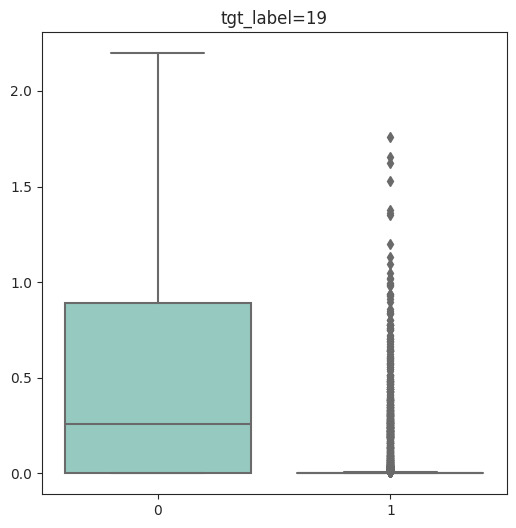

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 196, len(other_neuron_corr_sum): 2876


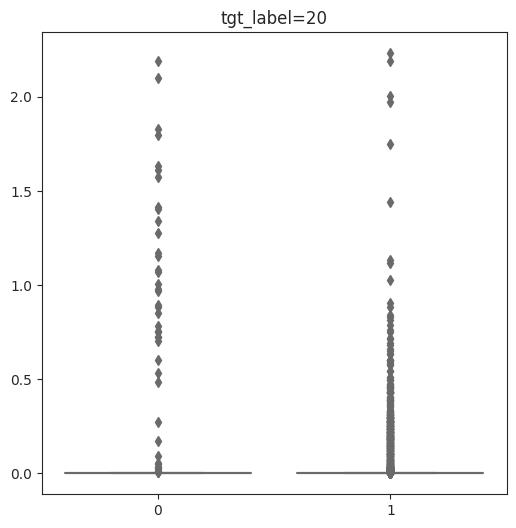

neg.


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 78, len(other_neuron_corr_sum): 2994


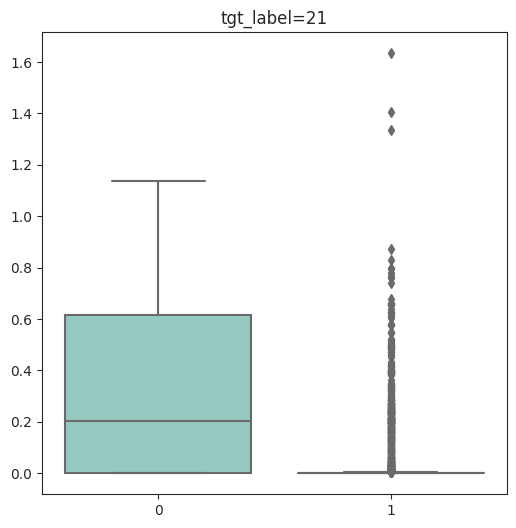

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 46, len(other_neuron_corr_sum): 3026


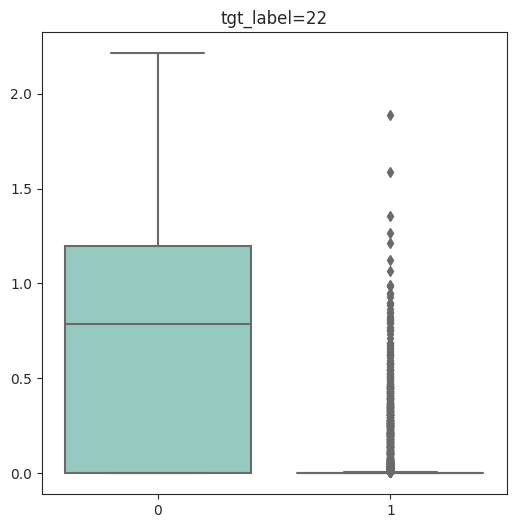

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 72, len(other_neuron_corr_sum): 3000


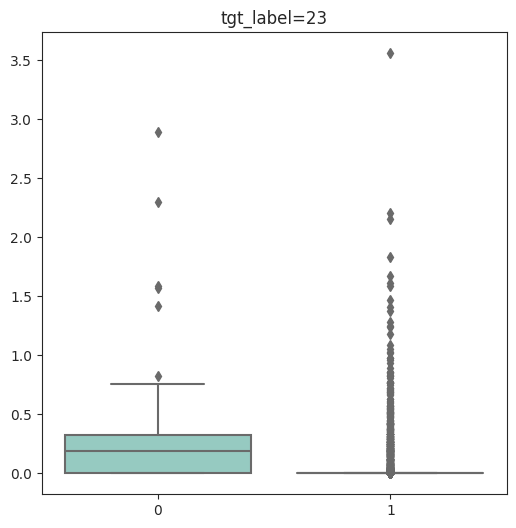

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 122, len(other_neuron_corr_sum): 2950


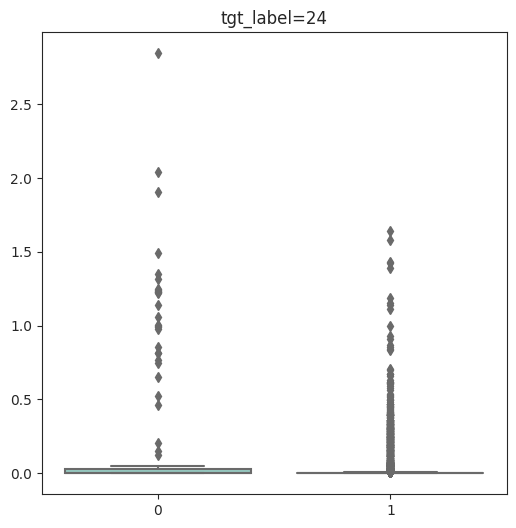

neg.*


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 106, len(other_neuron_corr_sum): 2966


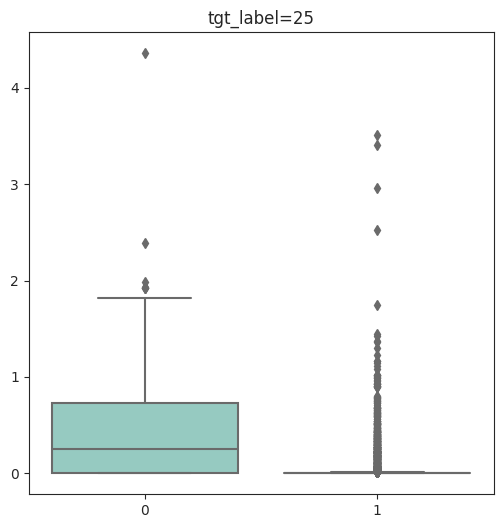

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 110, len(other_neuron_corr_sum): 2962


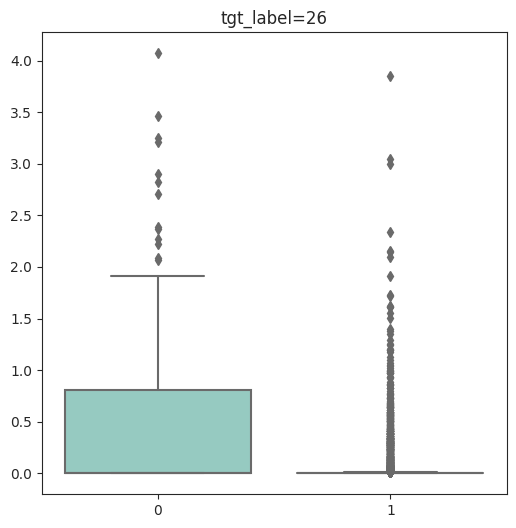

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 180, len(other_neuron_corr_sum): 2892


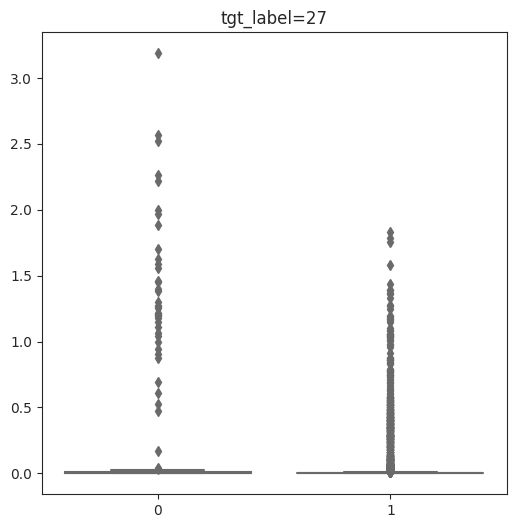

neg.*


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 47, len(other_neuron_corr_sum): 3025


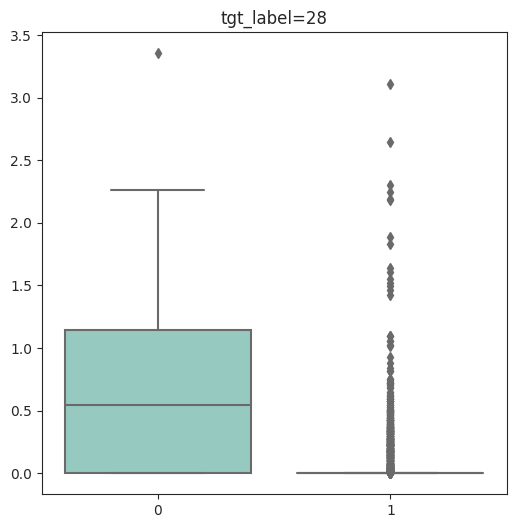

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 19, len(other_neuron_corr_sum): 3053


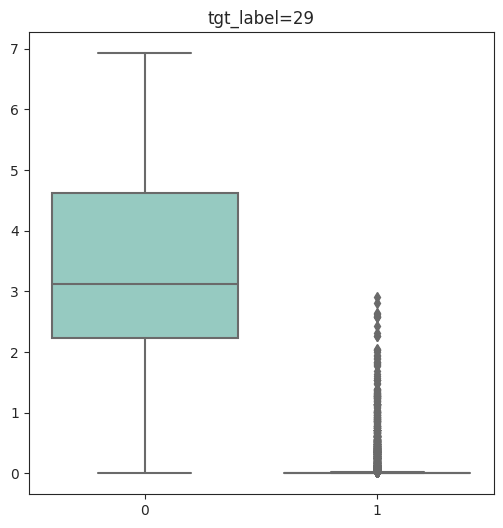

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 41, len(other_neuron_corr_sum): 3031


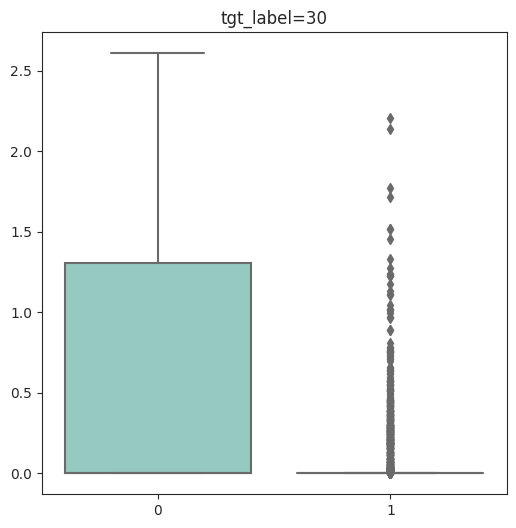

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 141, len(other_neuron_corr_sum): 2931


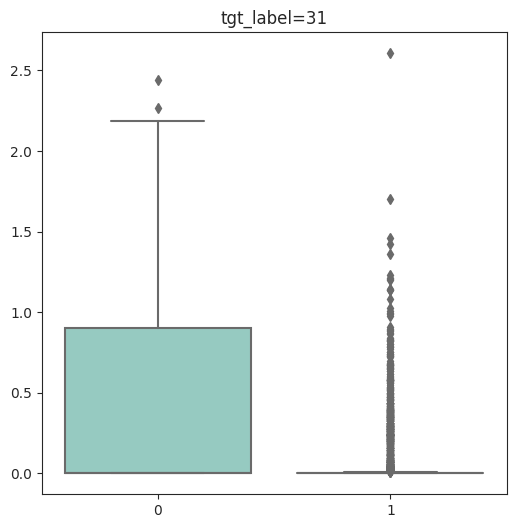

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 56, len(other_neuron_corr_sum): 3016


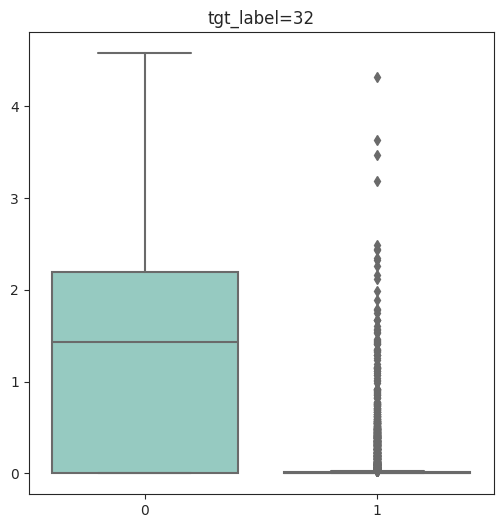

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 99, len(other_neuron_corr_sum): 2973


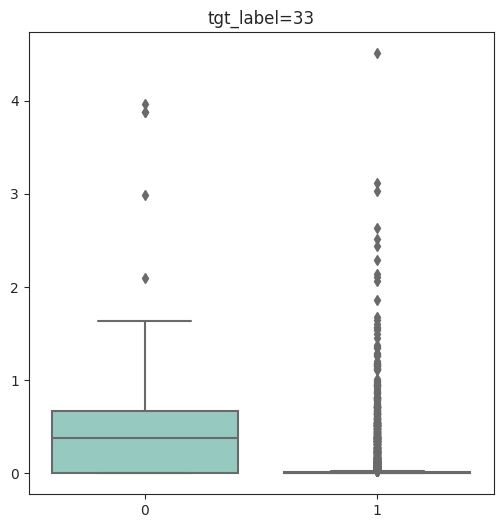

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 56, len(other_neuron_corr_sum): 3016


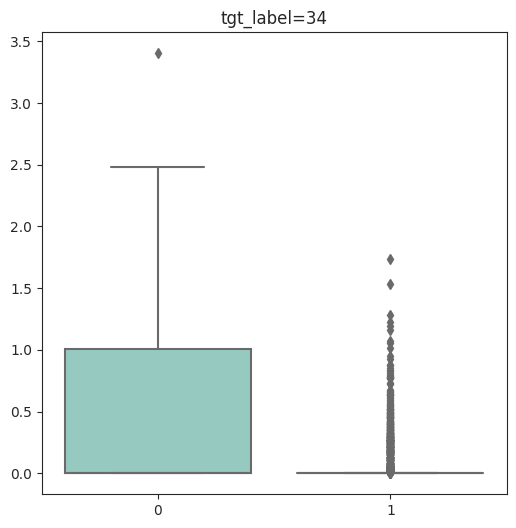

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 70, len(other_neuron_corr_sum): 3002


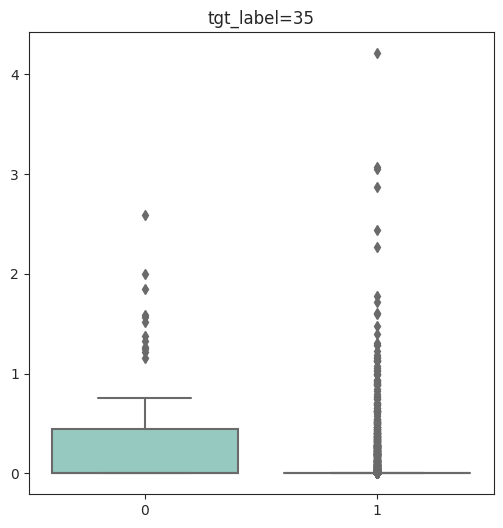

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 69, len(other_neuron_corr_sum): 3003


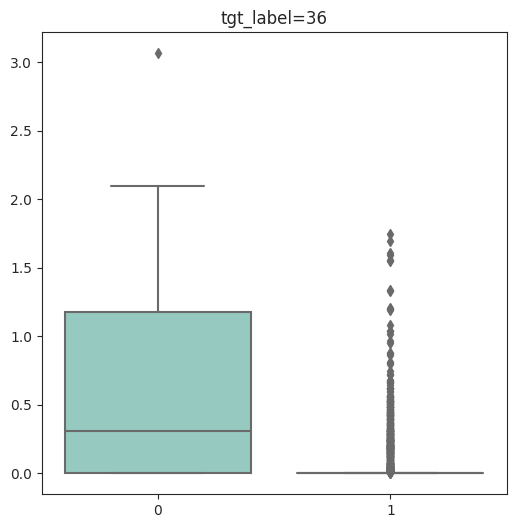

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 53, len(other_neuron_corr_sum): 3019


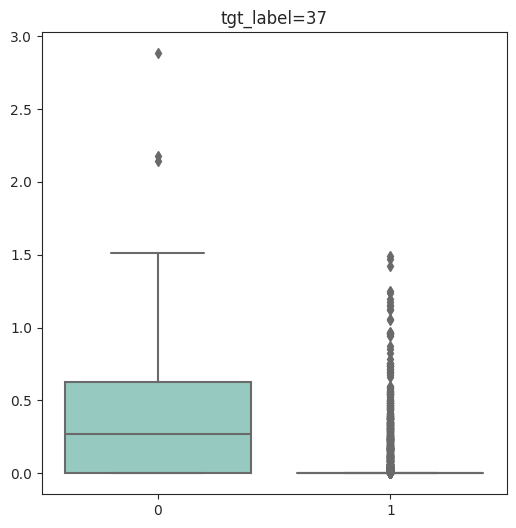

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 47, len(other_neuron_corr_sum): 3025


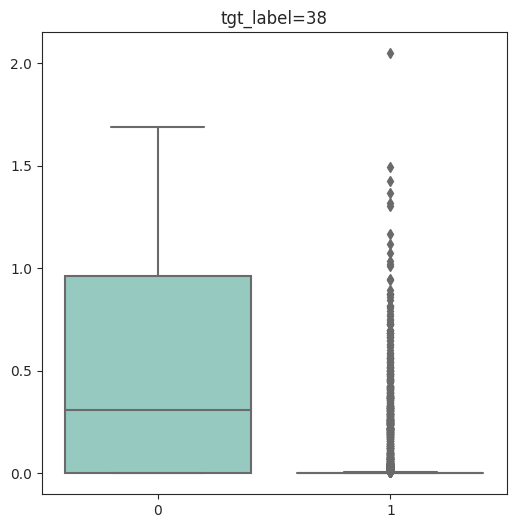

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 71, len(other_neuron_corr_sum): 3001


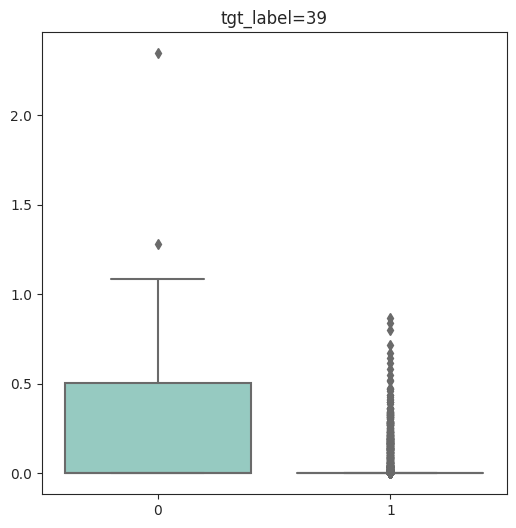

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 97, len(other_neuron_corr_sum): 2975


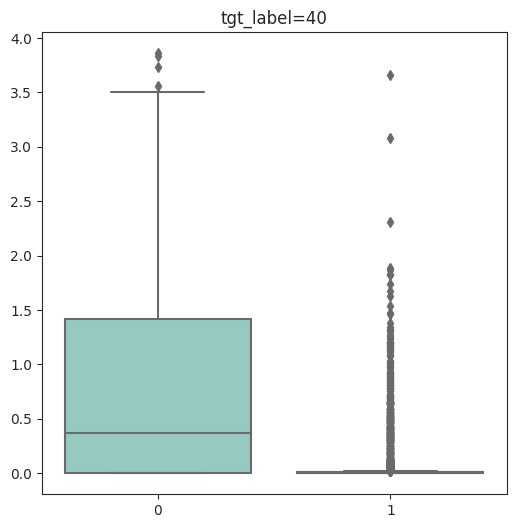

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 93, len(other_neuron_corr_sum): 2979


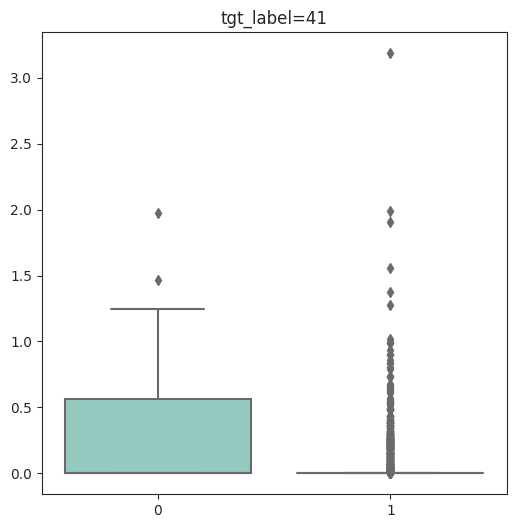

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 114, len(other_neuron_corr_sum): 2958


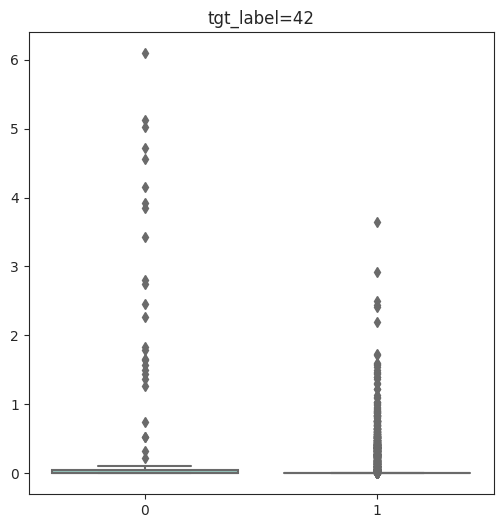

neg.


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 99, len(other_neuron_corr_sum): 2973


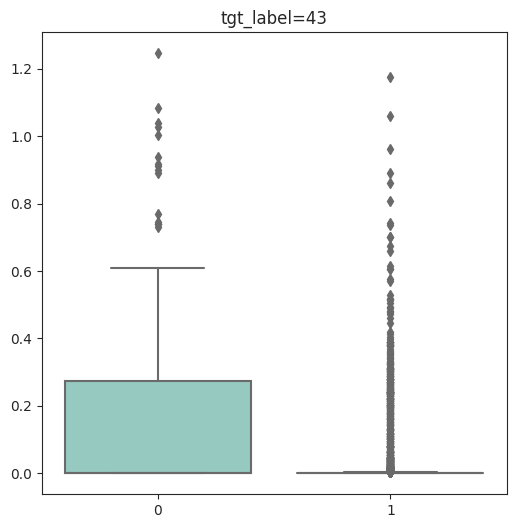

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 54, len(other_neuron_corr_sum): 3018


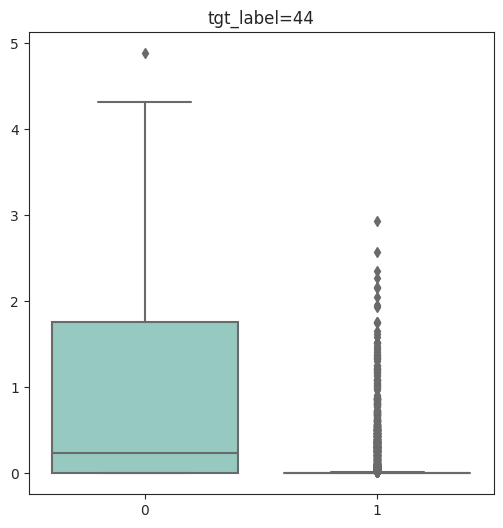

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 102, len(other_neuron_corr_sum): 2970


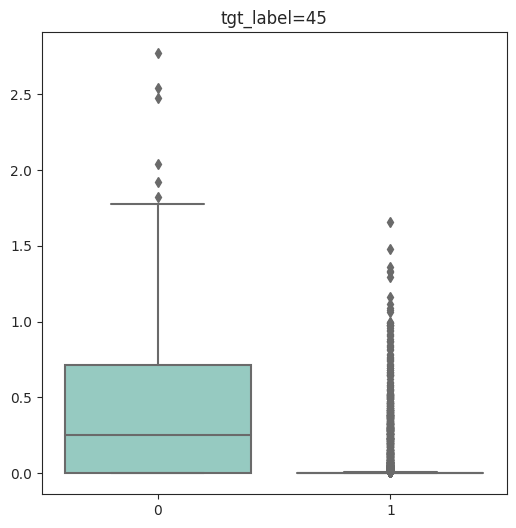

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 74, len(other_neuron_corr_sum): 2998


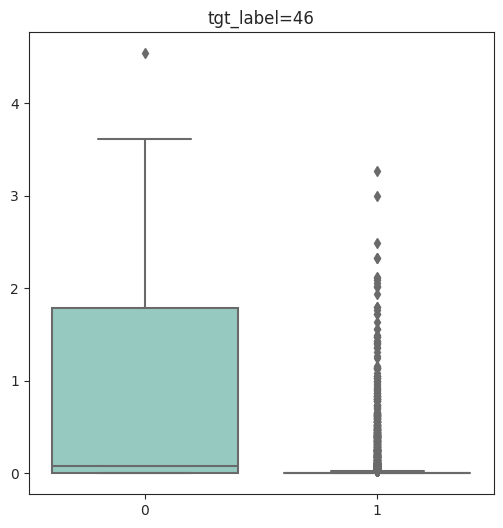

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 114, len(other_neuron_corr_sum): 2958


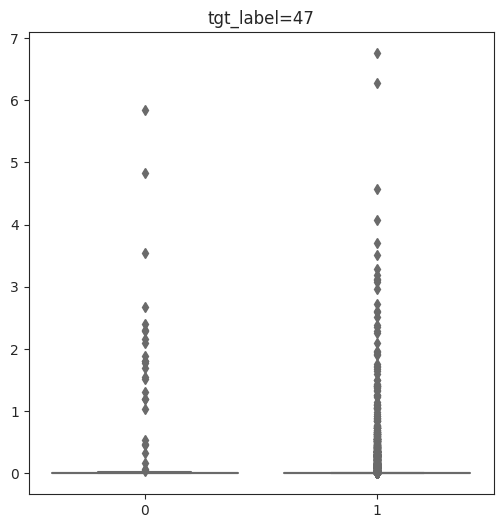

neg.*


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 115, len(other_neuron_corr_sum): 2957


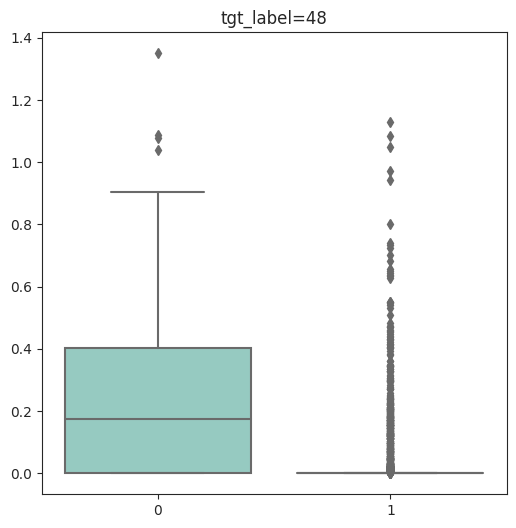

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 83, len(other_neuron_corr_sum): 2989


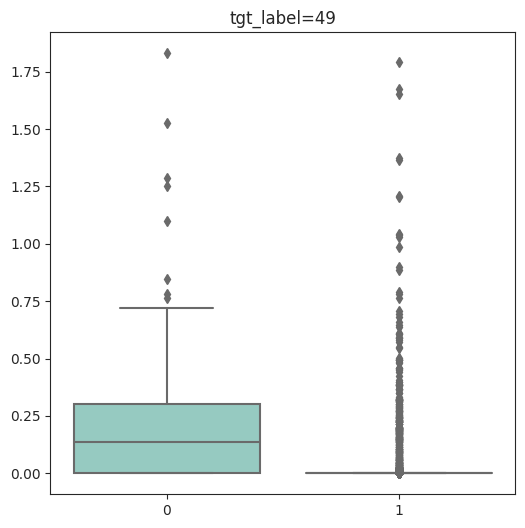

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 61, len(other_neuron_corr_sum): 3011


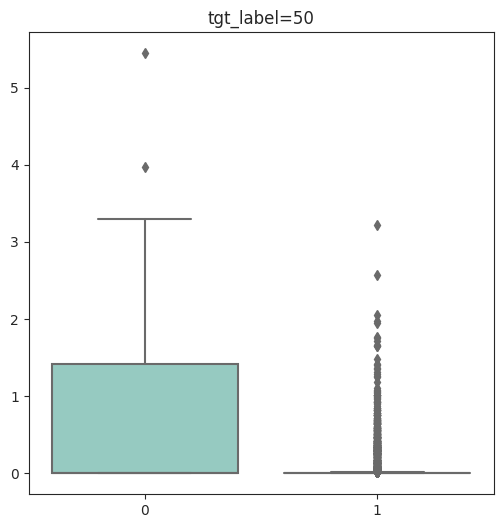

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 91, len(other_neuron_corr_sum): 2981


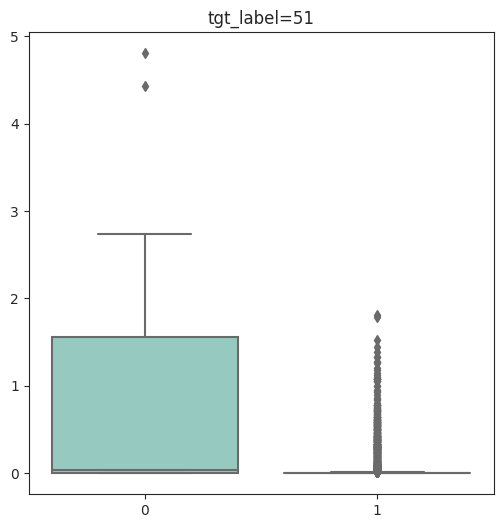

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 129, len(other_neuron_corr_sum): 2943


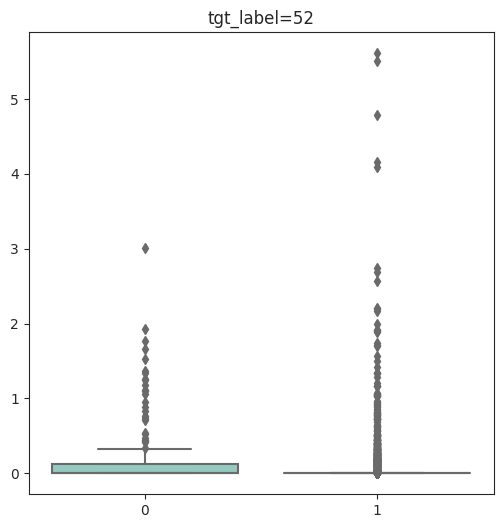

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 71, len(other_neuron_corr_sum): 3001


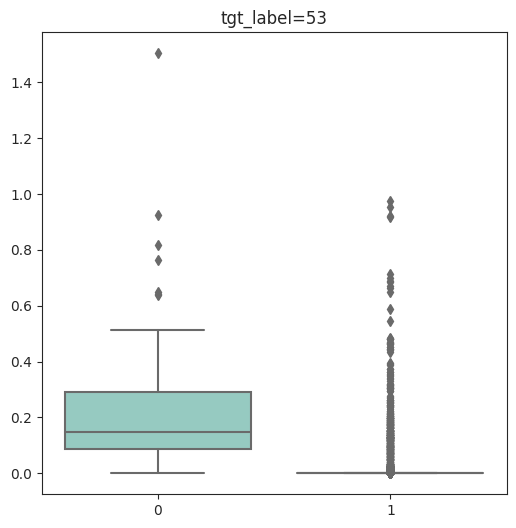

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 105, len(other_neuron_corr_sum): 2967


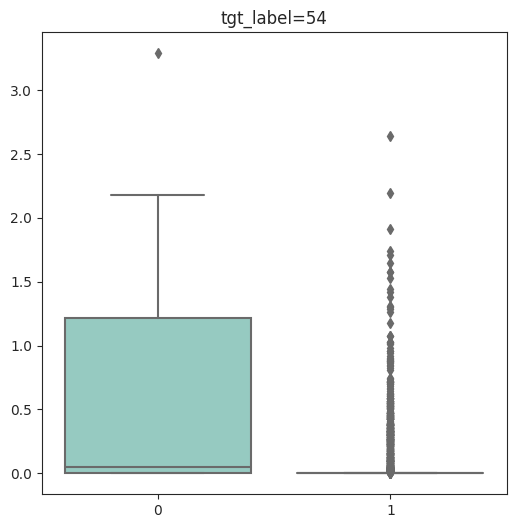

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 32, len(other_neuron_corr_sum): 3040


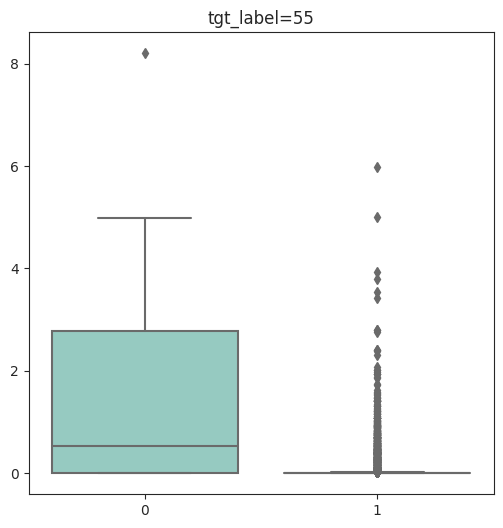

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 100, len(other_neuron_corr_sum): 2972


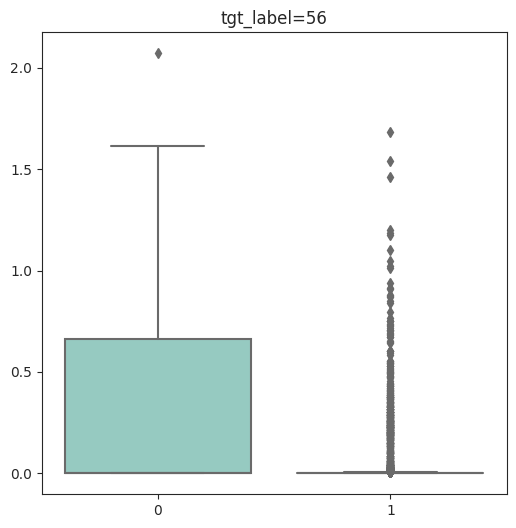

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 58, len(other_neuron_corr_sum): 3014


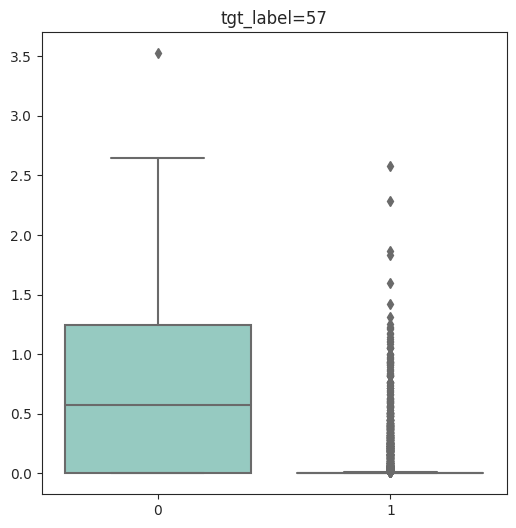

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 104, len(other_neuron_corr_sum): 2968


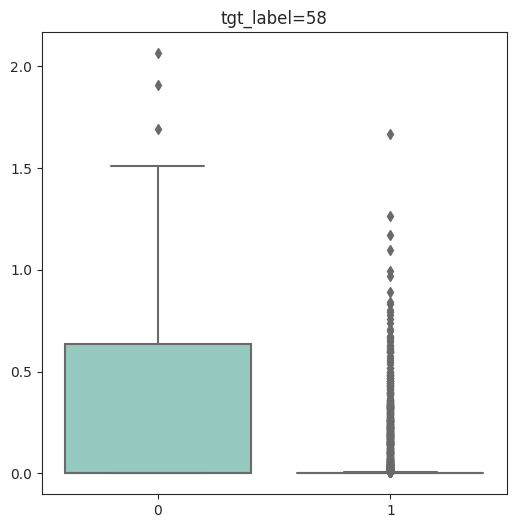

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 57, len(other_neuron_corr_sum): 3015


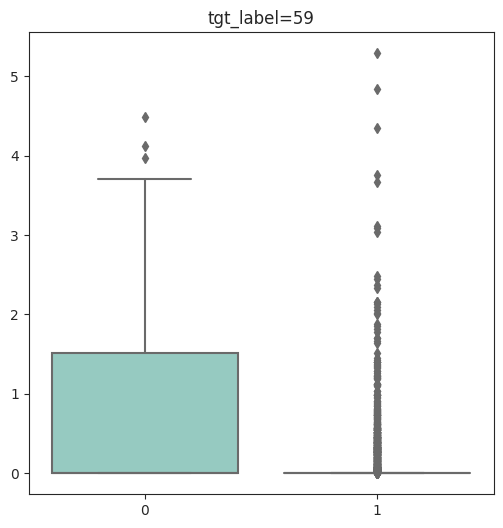

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 66, len(other_neuron_corr_sum): 3006


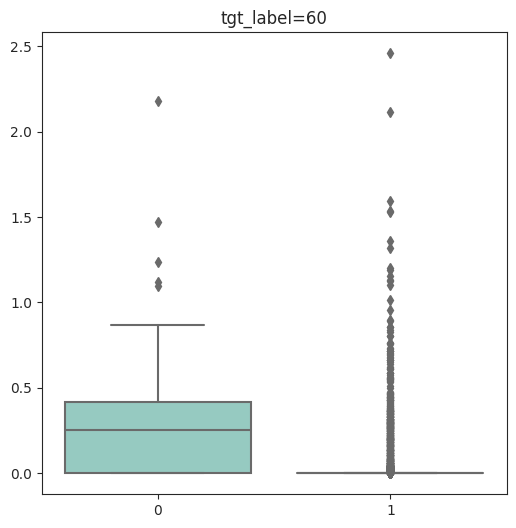

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 451, len(other_neuron_corr_sum): 2621


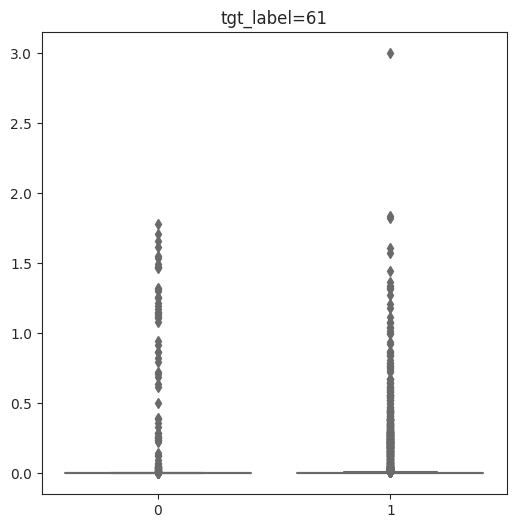

neg.


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 200, len(other_neuron_corr_sum): 2872


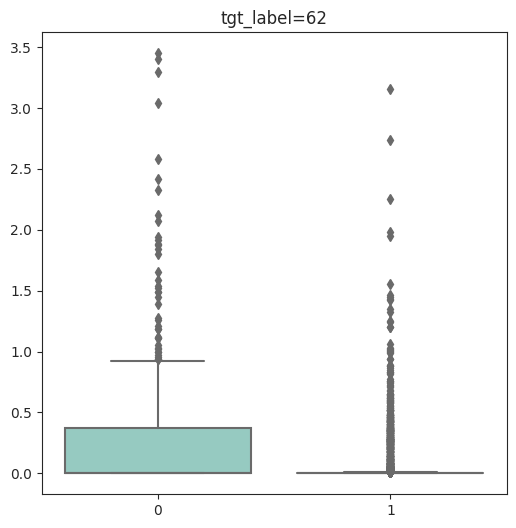

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 212, len(other_neuron_corr_sum): 2860


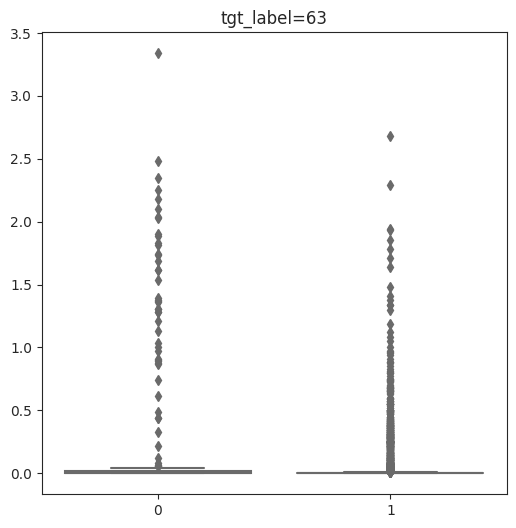

neg.


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 108, len(other_neuron_corr_sum): 2964


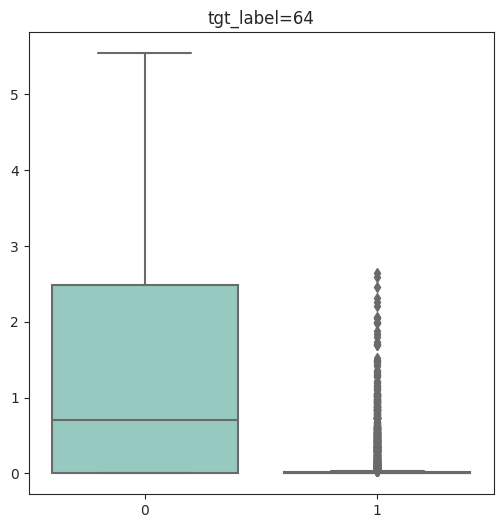

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 55, len(other_neuron_corr_sum): 3017


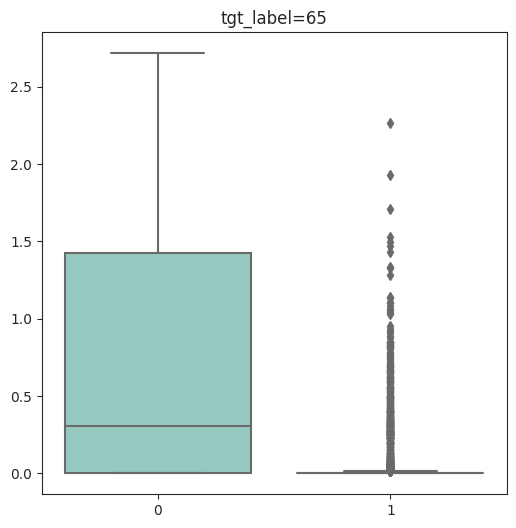

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 110, len(other_neuron_corr_sum): 2962


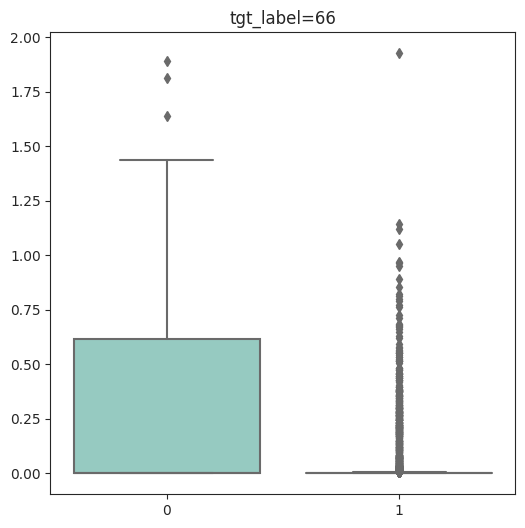

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 92, len(other_neuron_corr_sum): 2980


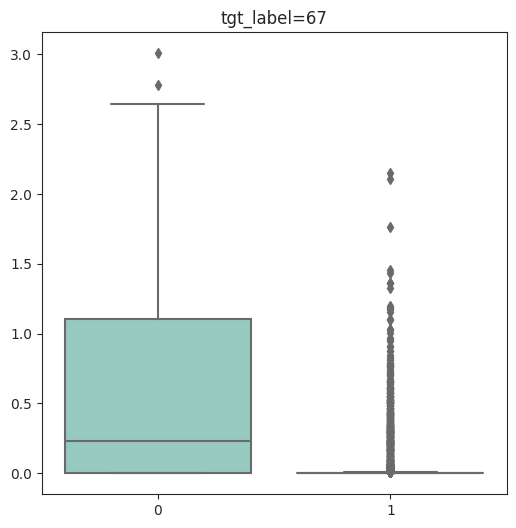

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 61, len(other_neuron_corr_sum): 3011


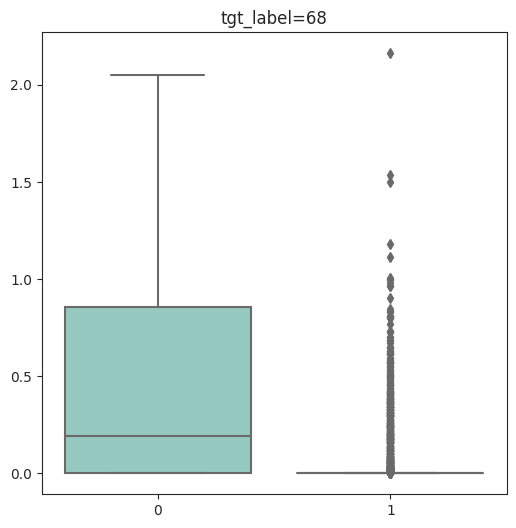

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 104, len(other_neuron_corr_sum): 2968


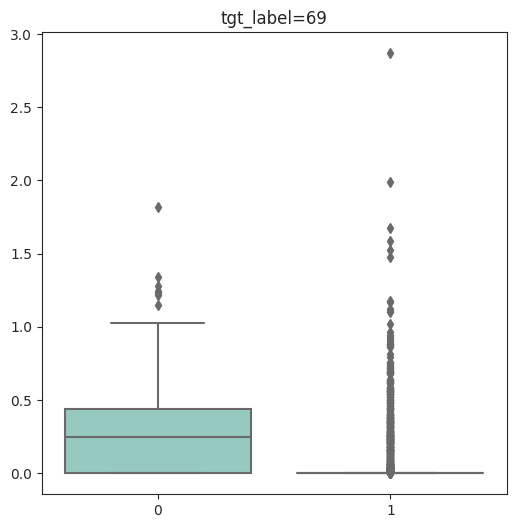

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 69, len(other_neuron_corr_sum): 3003


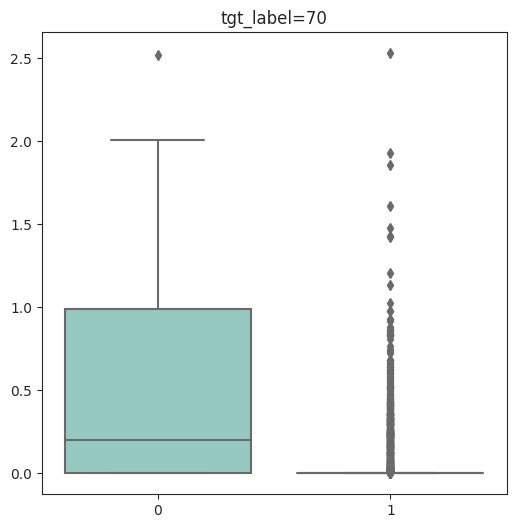

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 95, len(other_neuron_corr_sum): 2977


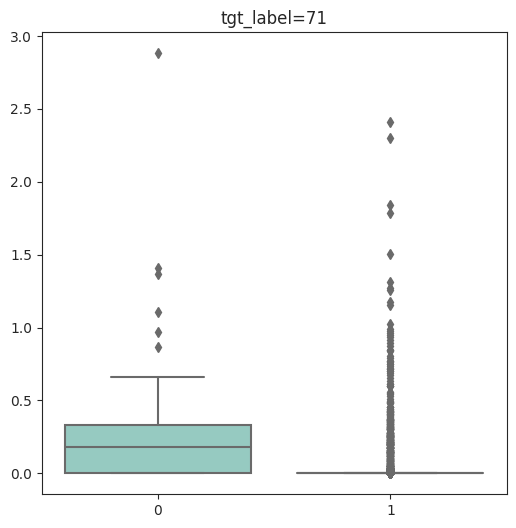

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 189, len(other_neuron_corr_sum): 2883


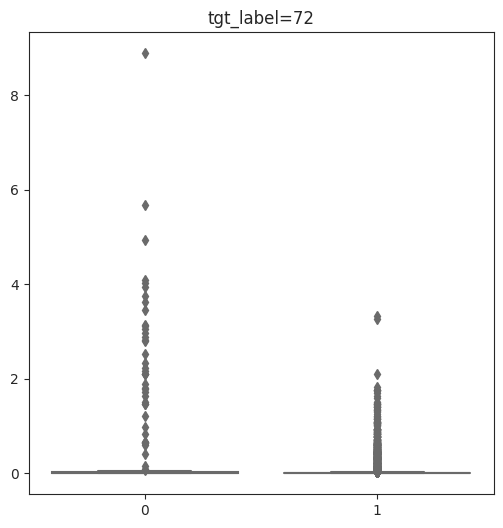

neg.


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 86, len(other_neuron_corr_sum): 2986


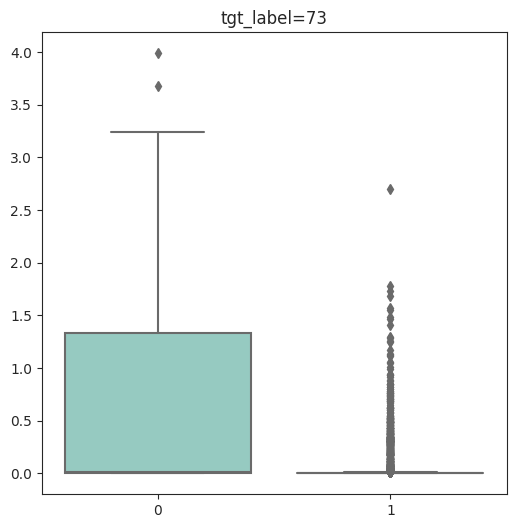

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 61, len(other_neuron_corr_sum): 3011


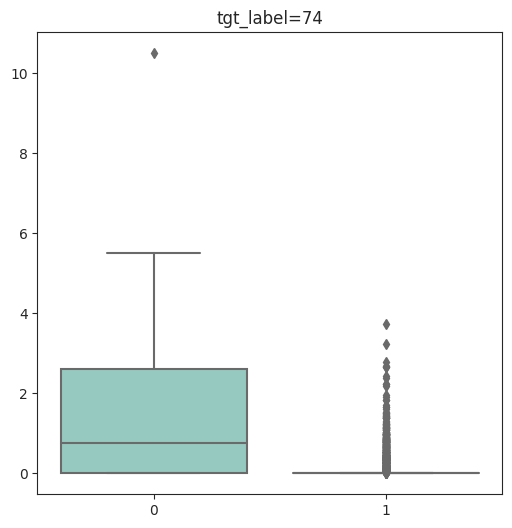

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 45, len(other_neuron_corr_sum): 3027


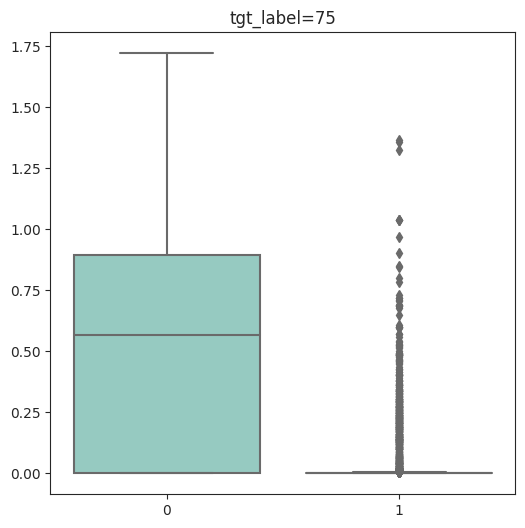

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 78, len(other_neuron_corr_sum): 2994


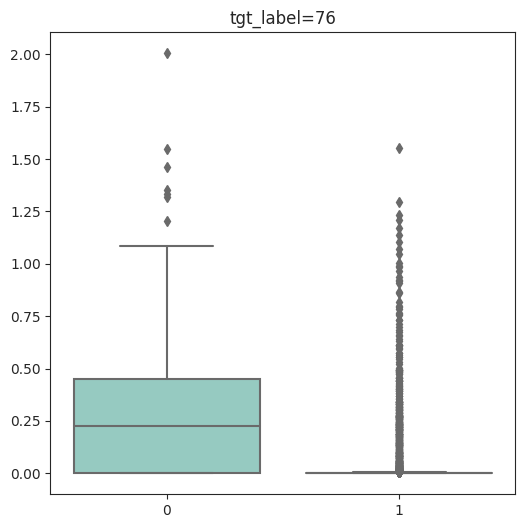

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 116, len(other_neuron_corr_sum): 2956


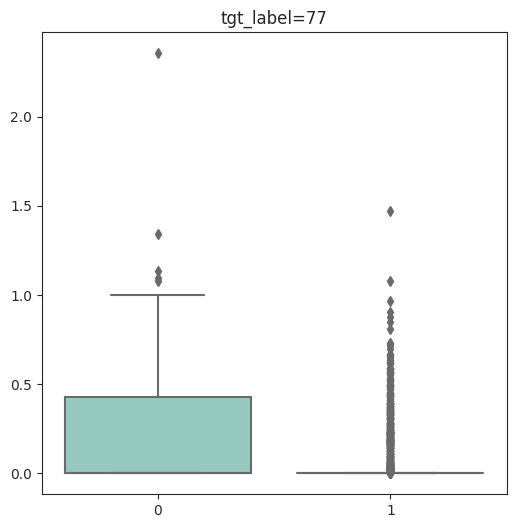

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 188, len(other_neuron_corr_sum): 2884


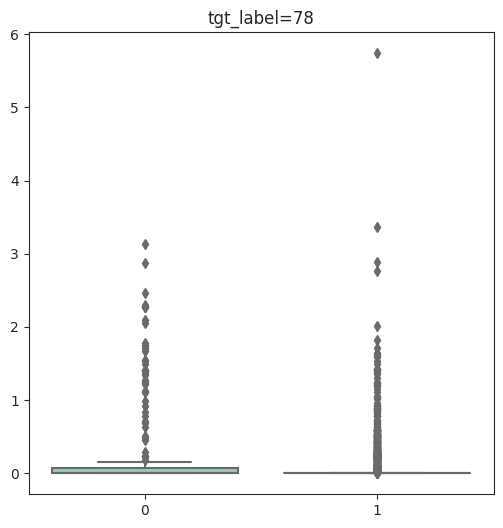

neg.


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 86, len(other_neuron_corr_sum): 2986


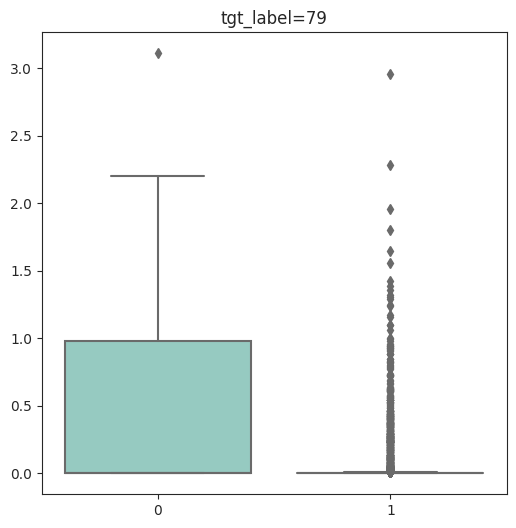

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 116, len(other_neuron_corr_sum): 2956


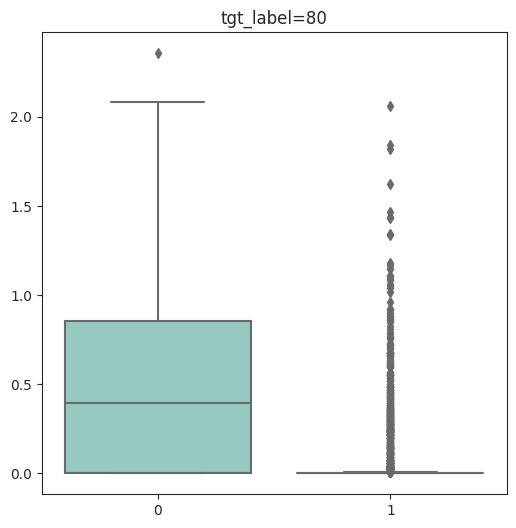

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 37, len(other_neuron_corr_sum): 3035


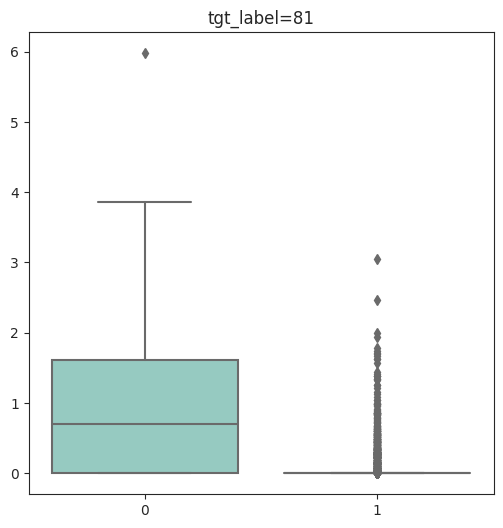

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 144, len(other_neuron_corr_sum): 2928


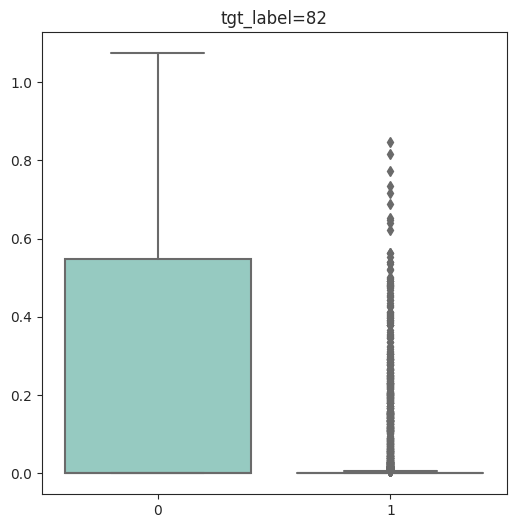

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 91, len(other_neuron_corr_sum): 2981


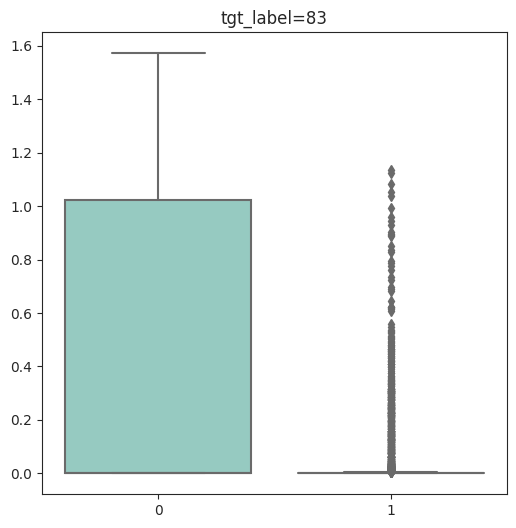

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 51, len(other_neuron_corr_sum): 3021


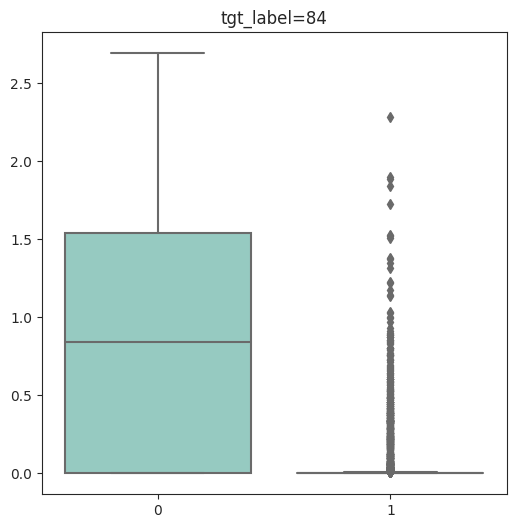

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 129, len(other_neuron_corr_sum): 2943


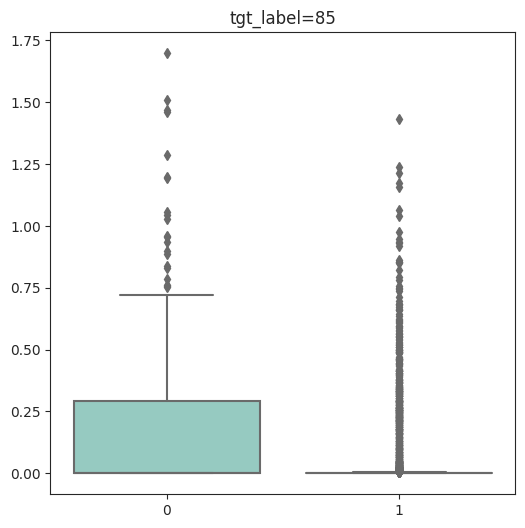

neg.*


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 52, len(other_neuron_corr_sum): 3020


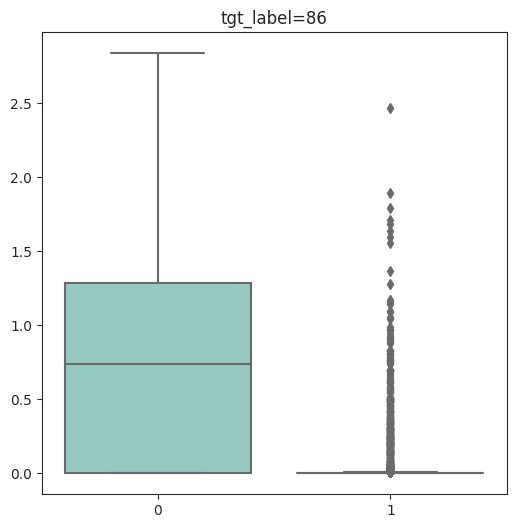

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 49, len(other_neuron_corr_sum): 3023


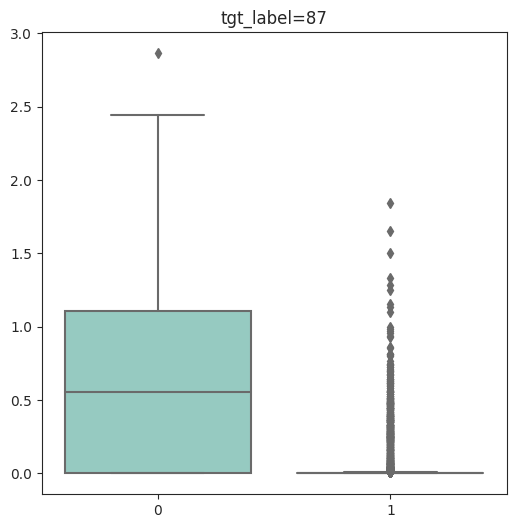

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 59, len(other_neuron_corr_sum): 3013


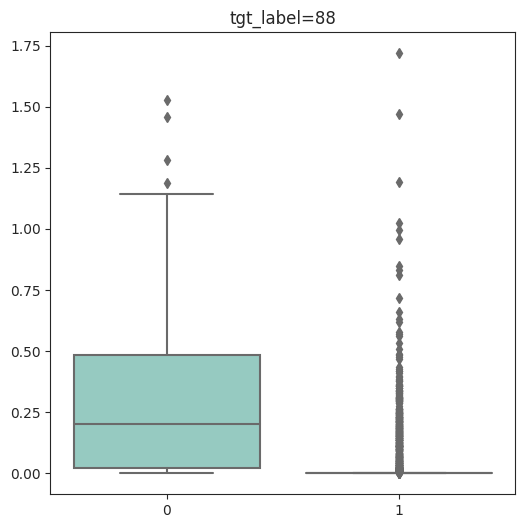

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 132, len(other_neuron_corr_sum): 2940


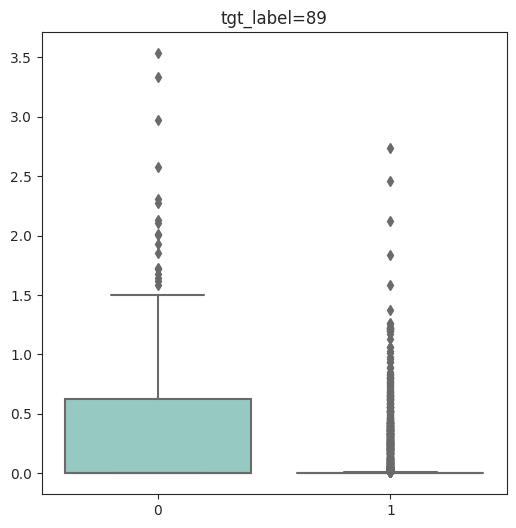

neg.*


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 104, len(other_neuron_corr_sum): 2968


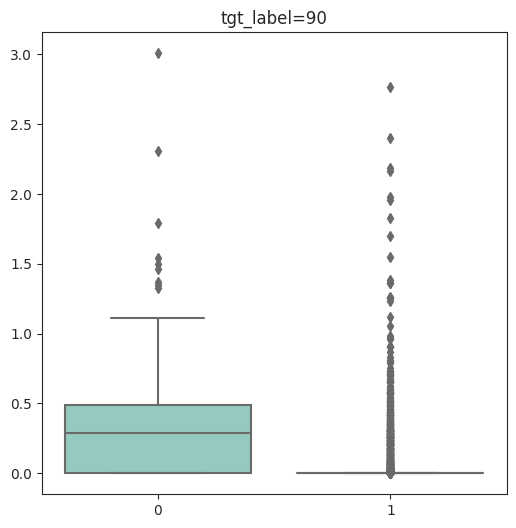

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 145, len(other_neuron_corr_sum): 2927


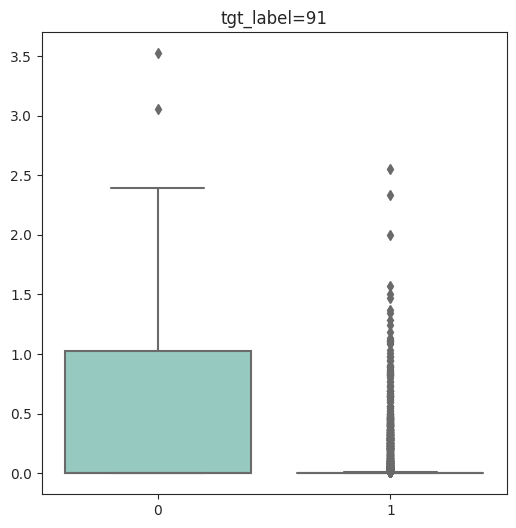

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 99, len(other_neuron_corr_sum): 2973


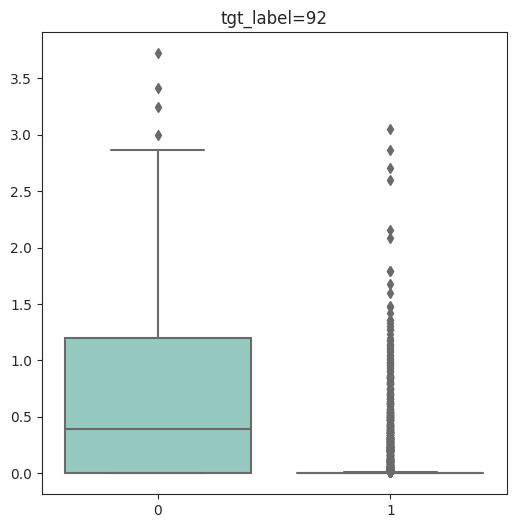

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 74, len(other_neuron_corr_sum): 2998


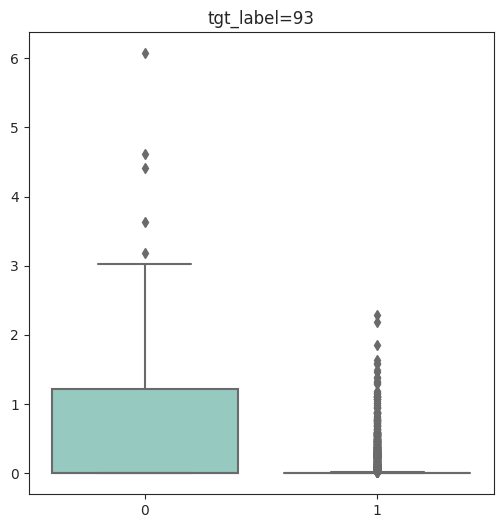

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 42, len(other_neuron_corr_sum): 3030


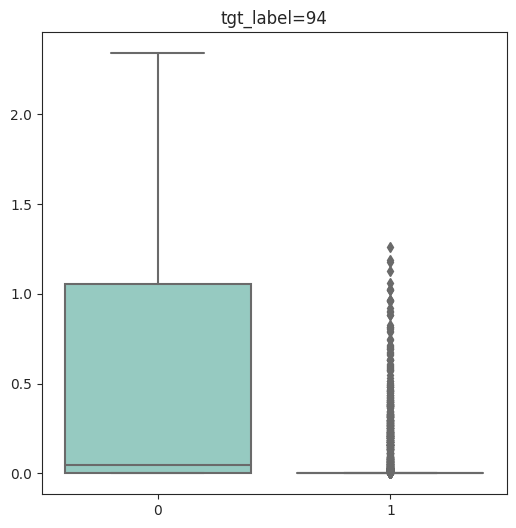

med.**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 60, len(other_neuron_corr_sum): 3012


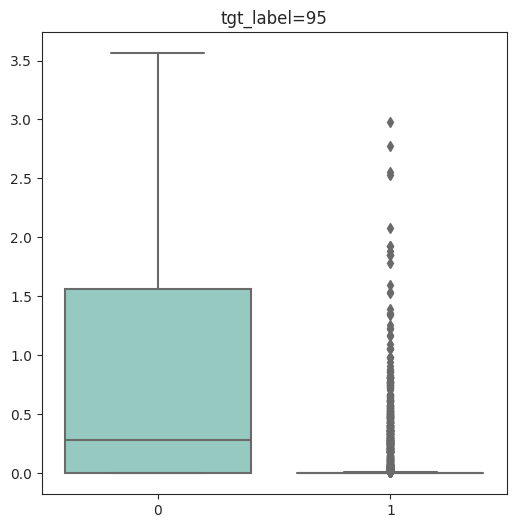

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 70, len(other_neuron_corr_sum): 3002


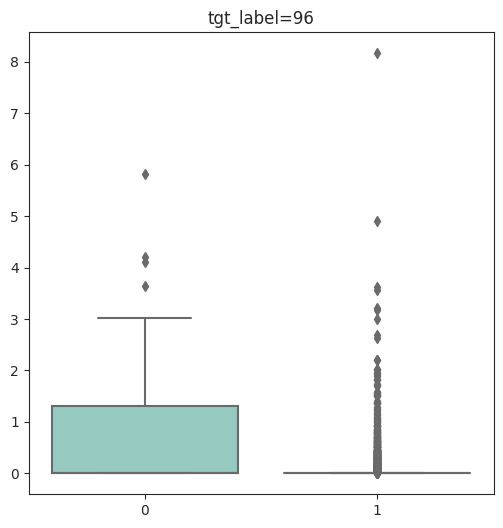

small**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 37, len(other_neuron_corr_sum): 3035


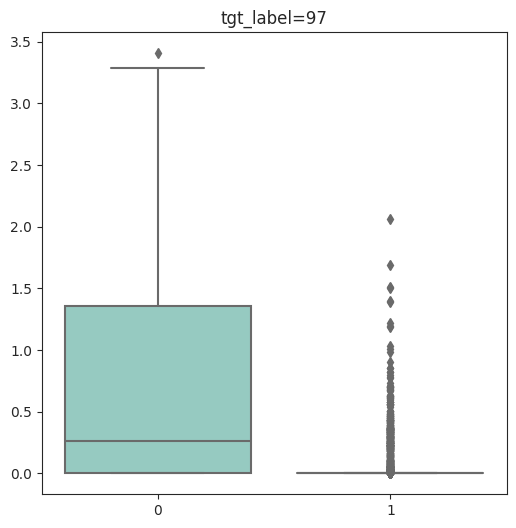

large**


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 125, len(other_neuron_corr_sum): 2947


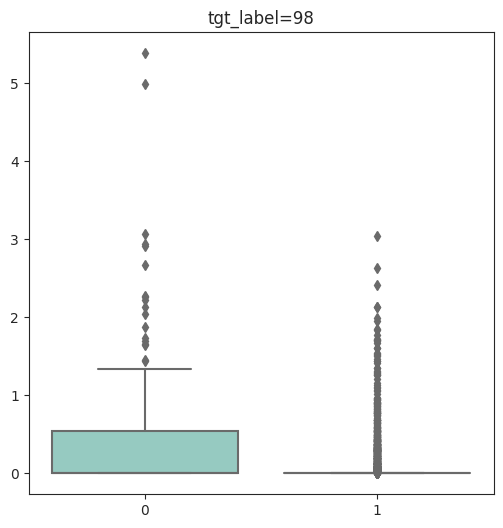

neg.*


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


len(tgt_neuron_corr_sum): 62, len(other_neuron_corr_sum): 3010


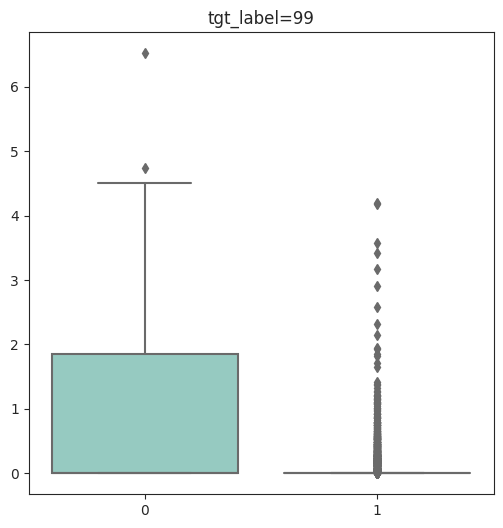

small**
86 21 34 31


In [23]:
# integrated gradientのdir
ig_dir = os.path.join(getattr(ViTExperiment, ds_name).OUTPUT_DIR, "neuron_scores")
im_dir = os.path.join(getattr(ViTExperiment, ds_name).OUTPUT_DIR, f"cache_states_{used_col}")
# 統計的有意で効果量largeなケースを保存するため
l_cnt = 0
m_cnt = 0
s_cnt = 0
sig_cnt = 0
for tgt_layer in range(start_li, end_li):
    if tgt_layer != 11:
        continue
    print(f"tgt_layer={tgt_layer}")
    im_states = torch.load(os.path.join(im_dir, f"intermediate_states_l{tgt_layer}.pt"))
    # numpyに変換しておく
    im_states = im_states.cpu().numpy()
    corr_per_label = []
    for tgt_label in tqdm(range(num_labels), desc="tgt_label"):
        # labelsがtgt_labelのindexを取得
        tgt_idx = np.where(labels == tgt_label)[0]
        # tgt_labelに対するim_statesだけを取得
        tgt_im = im_states[tgt_idx]
        # 対象のレイヤに対象のラベルのサンプルを入れたときのニューロン相関マップを作成
        neuron_corr = np.corrcoef(tgt_im, rowvar=False)
        # 対象のレイヤの各ニューロンの分散を求める
        neuron_var = np.var(tgt_im, axis=0)
        # 分散共分散行列
        neuron_cov = np.cov(tgt_im, rowvar=False)
        
        # # neuron_corrのヒートマップを可視化
        # plt.figure(figsize=(12, 12))
        # sns.heatmap(neuron_corr, cmap="coolwarm", center=0)
        # plt.title(f"tgt_label={tgt_label}")
        # plt.show()
    
        # neuron_corrの各行の和
        neuron_corr_sum = np.nansum(neuron_cov, axis=0)

        # # 分散と相関係数を合わせたneuron scoreを計算
        # # 重み付け係数
        # alpha = 1.0
        # beta = 1.0
        # # 総合スコアの計算
        # neuron_scores = alpha * neuron_corr_sum + beta * neuron_var
        mean_cov = (neuron_corr_sum - neuron_var) / (neuron_corr_sum.shape[0] - 1)
        neuron_score = neuron_var + mean_cov
        # neuron_score = (neuron_corr_sum.shape[0] - 1) * np.diag(neuron_cov) + np.sum(neuron_cov, axis=1)
        # # neuron_corr_sumのヒストグラムを可視化
        # plt.figure(figsize=(6, 6))
        # plt.hist(neuron_corr_sum.flatten(), bins=100) # 分散が0の変数があると0除算でnanが返される (warning出ます)
        # plt.title(f"tgt_label={tgt_label}")
        # plt.show()
        
        # tgt_labelに対するintegrated_gradientを取得
        kn_path = os.path.join(ig_dir, f"ig_list_l{start_li}tol{end_li}_{tgt_label}.json")
        json_data = json.load(open(kn_path, "r"))
        kn_pos = json_data["kn"] # knの位置のリスト, 各要素は [layer_index, neuron_index] のリスト
        # kn_posのlayer_indexがtgt_layerのものだけ取得
        tgt_kn_pos = [pos for pos in kn_pos if pos[0] == tgt_layer]
        # tgt_kn_posのneuron_indexだけ取得
        tgt_kn_idx = [pos[1] for pos in tgt_kn_pos]
        # tgt_kn_idx の neuron の neuron_scores だけ取得
        tgt_neuron_corr_sum = neuron_score[tgt_kn_idx]
        # tgt_kn_idx以外のものも取得
        other_neuron_corr_sum = np.delete(neuron_score, tgt_kn_idx)
        print(f"len(tgt_neuron_corr_sum): {len(tgt_neuron_corr_sum)}, len(other_neuron_corr_sum): {len(other_neuron_corr_sum)}")
        # tgt_neuron_corr_sumが空ならスキップ
        if len(tgt_neuron_corr_sum) == 0:
            continue
        
        # tgt_neuron_corr_sumとother_neuron_corr_sumを箱髭図で比較
        plt.figure(figsize=(6, 6))
        sns.boxplot(data=[tgt_neuron_corr_sum, other_neuron_corr_sum], palette="Set3")
        plt.title(f"tgt_label={tgt_label}")
        plt.show()

        # tgt_neuron_corr_sumとother_neuron_corr_sumをU検定
        u, p = stats.mannwhitneyu(tgt_neuron_corr_sum, other_neuron_corr_sum, alternative="greater")
        d_cliff = 2*u/(len(tgt_neuron_corr_sum)*len(other_neuron_corr_sum)) - 1
        sig, eff, sign = judge_test_res(p, d_cliff)
        # if sig != "":
        if sig == "**":
            sig_cnt += 1
            if eff == "large":
                l_cnt += 1
            elif eff == "med.":
                m_cnt += 1
            elif eff == "small":
                s_cnt += 1
print(sig_cnt, s_cnt, m_cnt, l_cnt)